# Graph Neural Network (GNN)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, matthews_corrcoef, balanced_accuracy_score, 
                             cohen_kappa_score, confusion_matrix)

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

c:\Users\raksh\anaconda3\envs\unet_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


In [3]:
pip install torch-geometric

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ------------------ --------------------- 0.5/1.1 MB 882.6 kB/s eta 0:00:01
   ------------------ --------------------- 0.5/1.1 MB 882.6 kB/s eta 0:00:01
   --------------------------- ------------ 0.8/1.1 MB 685.3 kB/s eta 0:00:01
   --------------------------- ------------ 0.8/1.1 MB 685.3 kB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 698.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
df = pd.read_csv('dataset.csv')

C:\Users\raksh\AppData\Local\Temp\ipykernel_164\112859877.py:1: DtypeWarning: Columns (22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


In [6]:
def get_engine_status(row):
    dtc = str(row['DTC_NUMBER']).strip() if pd.notnull(row['DTC_NUMBER']) else ""
    tc = str(row['TROUBLE_CODES']).strip() if pd.notnull(row['TROUBLE_CODES']) else ""
    # Rule: if DTC_NUMBER equals "MIL is OFF1" OR TROUBLE_CODES is nonblank and starts with "P"
    if dtc == "MIL is OFF1" or (tc != "" and tc.upper().startswith("P")):
        return 1  # malfunctioning
    else:
        return 0  # healthy

In [7]:
cols_to_drop = [
    'AUTOMATIC', 'BAROMETRIC_PRESSURE(KPA)', 'FUEL_LEVEL', 'AMBIENT_AIR_TEMP', 
    'INTAKE_MANIFOLD_PRESSURE', 'MAF', 'LONG TERM FUEL TRIM BANK 2', 'FUEL_TYPE', 
    'FUEL_PRESSURE', 'SHORT TERM FUEL TRIM BANK 2', 'ENGINE_RUNTIME', 
    'EQUIV_RATIO', 'TIMESTAMP', 'VEHICLE_ID'
]
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

In [8]:
feature_cols = [
    'MARK', 'MODEL', 'CAR_YEAR', 'ENGINE_POWER', 'ENGINE_COOLANT_TEMP', 
    'ENGINE_LOAD', 'ENGINE_RPM', 'AIR_INTAKE_TEMP', 'SPEED', 
    'SHORT TERM FUEL TRIM BANK 1', 'THROTTLE_POS', 'TIMING_ADVANCE', 
    'MIN', 'HOURS', 'DAYS_OF_WEEK', 'MONTHS', 'YEAR'
]
df_model = df[feature_cols + ['DTC_NUMBER', 'TROUBLE_CODES']].copy()
df_model['EngineStatus'] = df_model.apply(get_engine_status, axis=1)
df_model.dropna(subset=['EngineStatus'], inplace=True)

In [9]:
X = df_model[feature_cols]
y = df_model['EngineStatus'].values  # as a numpy array
meta_info = df_model[['DTC_NUMBER', 'TROUBLE_CODES']]

In [10]:
categorical_features = ['MARK', 'MODEL']
numeric_features = [col for col in feature_cols if col not in categorical_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [11]:
X_processed = preprocessor.fit_transform(X)  # shape: (n_samples, d)
n_samples, d = X_processed.shape

In [12]:
# k-NN graph with k = 5 (each node connects to its 5 nearest neighbors).
k = 5
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(X_processed)
distances, indices = nbrs.kneighbors(X_processed)
edge_index_list = []
for i in range(n_samples):
    # Skip the first neighbor (self-loop)
    for j in indices[i, 1:]:
        edge_index_list.append([i, j])
edge_index = np.array(edge_index_list).T  # shape: (2, num_edges)
edge_index = torch.tensor(edge_index, dtype=torch.long)

In [13]:
x_tensor = torch.tensor(X_processed, dtype=torch.float)  # Node features
y_tensor = torch.tensor(y, dtype=torch.long)

In [14]:
all_indices = np.arange(n_samples)
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42)
train_mask = torch.zeros(n_samples, dtype=torch.bool)
test_mask = torch.zeros(n_samples, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

In [15]:
data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)
data.train_mask = train_mask
data.test_mask = test_mask

## Defining the GNN model

In [21]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 1)  # Output a single value per node.
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        # Use sigmoid to get probabilities for binary classification.
        return torch.sigmoid(x).squeeze()

in_channels = d
model_gnn = GCN(in_channels, hidden_channels=64)
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

### Training the Model

In [ ]:
model_gnn.train()
for epoch in range(10):
    optimizer.zero_grad()
    out = model_gnn(data)
    # Compute loss only on training nodes.
    loss = criterion(out[data.train_mask], data.y[data.train_mask].float())
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")

Epoch 000, Loss: 0.9176
Epoch 001, Loss: 0.6509
Epoch 002, Loss: 0.4695
Epoch 003, Loss: 0.3414
Epoch 004, Loss: 0.2541
Epoch 005, Loss: 0.1943
Epoch 006, Loss: 0.1543
Epoch 007, Loss: 0.1244
Epoch 008, Loss: 0.1035
Epoch 009, Loss: 0.0888


### Evaluation of the model

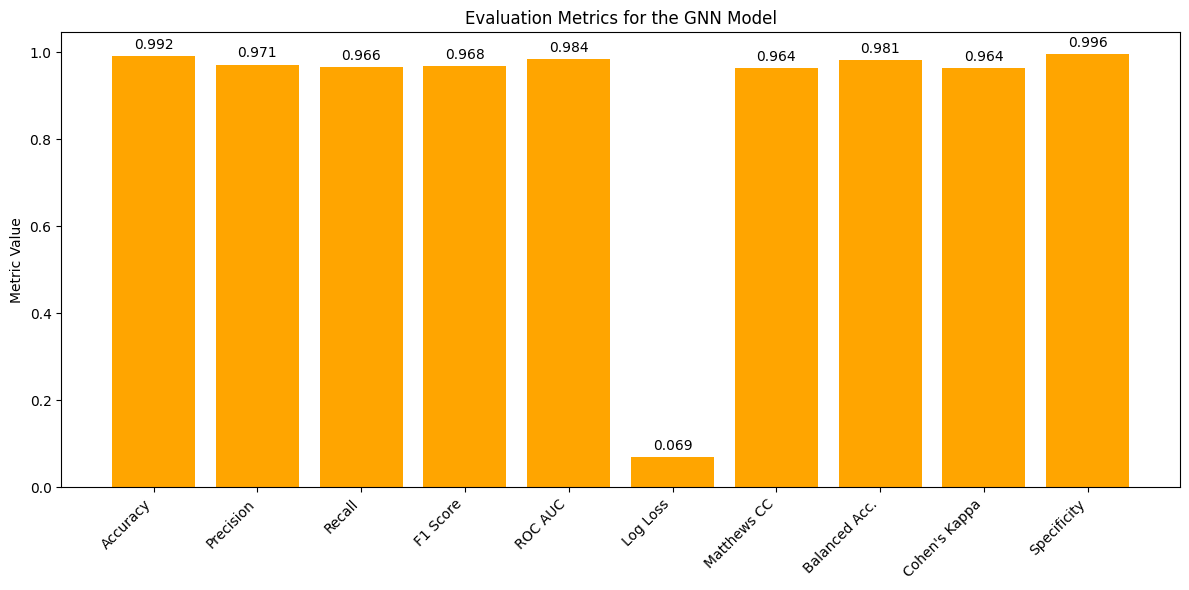

Sample 15805: Prediction: No malfunctioning
Sample 33942: Prediction: No malfunctioning
Sample 14577: Prediction: No malfunctioning
Sample 6113: Prediction: No malfunctioning
Sample 28348: Prediction: No malfunctioning
Sample 15039: Prediction: No malfunctioning
Sample 40224: Prediction: No malfunctioning
Sample 13197: Prediction: No malfunctioning
Sample 39394: Prediction: No malfunctioning
Sample 13988: Prediction: No malfunctioning
Sample 37140: Prediction: No malfunctioning
Sample 32396: Prediction: No malfunctioning
Sample 31374: Prediction: No malfunctioning
Sample 5692: Prediction: No malfunctioning
Sample 43455: Prediction: No malfunctioning
Sample 8761: Prediction: No malfunctioning
Sample 32445: Prediction: No malfunctioning
Sample 41419: Prediction: No malfunctioning
Sample 40145: Prediction: No malfunctioning
Sample 20831: Prediction: No malfunctioning
Sample 30899: Prediction: No malfunctioning
Sample 21109: Prediction: No malfunctioning
Sample 19826: Prediction: No malfun

In [ ]:
model_gnn.eval()
with torch.no_grad():
    out = model_gnn(data)
    y_pred_prob = out[data.test_mask].cpu().numpy()
    y_pred = (y_pred_prob >= 0.5).astype(int)
    y_true = data.y[data.test_mask].cpu().numpy()


acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob)
ll = log_loss(y_true, y_pred_prob)
mcc = matthews_corrcoef(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

metrics_dict_gnn = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1,
    "ROC AUC": roc_auc,
    "Log Loss": ll,
    "Matthews CC": mcc,
    "Balanced Acc.": bal_acc,
    "Cohen's Kappa": kappa,
    "Specificity": specificity
}

plt.figure(figsize=(12, 6))
bars = plt.bar(metrics_dict_gnn.keys(), metrics_dict_gnn.values(), color='orange')
plt.title("Evaluation Metrics for the GNN Model")
plt.ylabel("Metric Value")
plt.xticks(rotation=45, ha="right")
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
plt.tight_layout()
plt.show()

predictions_df = meta_info.iloc[test_indices].copy()
predictions_df['Predicted_Status'] = y_pred
predictions_df['Prediction'] = predictions_df['Predicted_Status'].apply(
    lambda x: "Malfunctioning" if x == 1 else "No malfunctioning"
)

for idx, row in predictions_df.iterrows():
    if row['Predicted_Status'] == 1:
        print(f"Sample {idx}: DTC_NUMBER: {row['DTC_NUMBER']}, TROUBLE_CODES: {row['TROUBLE_CODES']} -> Prediction: Malfunctioning")
    else:
        print(f"Sample {idx}: Prediction: No malfunctioning")